# Parallel jobs on Aquila

For jobs with a small number of registers one should make sure to maximize the full area allowed by the simulator. In this tutorial we go through the previously explored checkerboad preparation but now taking advantage of the full simulation area. 

We will break up each portion of the total area into __batches__ which will all run in parallel. 


## Defining batches

First we will define a _single_ batch containing a 3x3 grid of atoms

In [2]:
from braket.ahs.hamiltonian import Hamiltonian
from braket.ahs.atom_arrangement import AtomArrangement
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation

In [3]:
import numpy as np

# distance between atoms
scale = 5.6e-6

# number of atoms in a batch
Lx = 3
Ly = 3

register = AtomArrangement()

for ix in range(Lx):
    for iy in range(Ly):
        pos = (ix * scale,iy * scale)
        register.add(pos)

## Bounding batches

Next we define a box that bounds the batch by calculating its width and height. This will prove useful in setting up multiple batches in parallel in the area Aquila provides.

In [4]:
x_min = min(*[site.coordinate[0] for site in register])
x_max = max(*[site.coordinate[0] for site in register])
y_min = min(*[site.coordinate[1] for site in register])
y_max = max(*[site.coordinate[1] for site in register])

single_problem_width = x_max - x_min
single_problem_height = y_max - y_min

### Calculating batch placement

Each batch consists of an area proportional the the bounding box of the register as well as padding to make sure each batch is sufficiently isolated from one another to prevent entanglement between results via the Rydberg interaction. 

In this case we pick the distance between the batches to be:

$$3 \ \times \text{scale}$$

which means the inter-batch interaction is at most:

$$\frac{1}{3^6} \ \approx \ 0.001372$$ times the interactions within each batch.

In [ ]:
import numpy as np
from braket.ahs.atom_arrangement import AtomArrangement, SiteType
from braket.aws import AwsDevice
import json

qpu = AwsDevice("arn:aws:braket:us-east-1::device/qpu/quera/Aquila")

# get values from device capabilities
field_of_view_width = qpu.properties.paradigm.lattice.area.width
field_of_view_height = qpu.properties.paradigm.lattice.area.height
n_site_max = qpu.properties.paradigm.lattice.geometry.numberSitesMax

# set distance between batches to be 3 x scale
interproblem_distance = 3*scale
# setting up a grid of problems filling the total area
n_width = int(float(field_of_view_width)   // (single_problem_width  + interproblem_distance))
n_height = int(float(field_of_view_height) // (single_problem_height + interproblem_distance))

### Generating registers for all batches

We now loop over `n_width` and `n_height` to create the total set of registers that will run on the QPU. 

We will keep track of which set of registers (by atom number) belongs to which batch using a dictionary called `batch_mapping`.

We stop generating batches once we have reached the maximum number of sites allowed by the QPU. In this case we check to make sure we can fit the necessary number of atoms into a batch in case the number of atoms per batch is not a factor of `n_site_max`. 

In [ ]:
batch_mapping = dict()
parallel_register = AtomArrangement()

atom_number = 0 #counting number of atoms added

for ix in range(n_width):
    x_shift = ix * (single_problem_width   + interproblem_distance)

    for iy in range(n_height):    
        y_shift = iy * (single_problem_height  + interproblem_distance)

        # reached the maximum number of batches possible given n_site_max
        if atom_number + len(register) > n_site_max: break 

        atoms = []
        for site in register:
            new_coordinate = (x_shift + site.coordinate[0], y_shift + site.coordinate[1])
            parallel_register.add(new_coordinate,site.site_type)

            atoms.append(qubit_number)

            atom_number += 1

        batch_mapping[(ix,iy)] = qubits

In [34]:
# Key indicates the position of the batch itself on a unitless grid, 
# with dictionary value being the atom number
batch_mapping

{(0, 0): [0, 1, 2, 3, 4, 5, 6, 7, 8],
 (0, 1): [9, 10, 11, 12, 13, 14, 15, 16, 17],
 (0, 2): [18, 19, 20, 21, 22, 23, 24, 25, 26],
 (1, 0): [27, 28, 29, 30, 31, 32, 33, 34, 35],
 (1, 1): [36, 37, 38, 39, 40, 41, 42, 43, 44],
 (1, 2): [45, 46, 47, 48, 49, 50, 51, 52, 53]}

<Figure size 640x480 with 0 Axes>

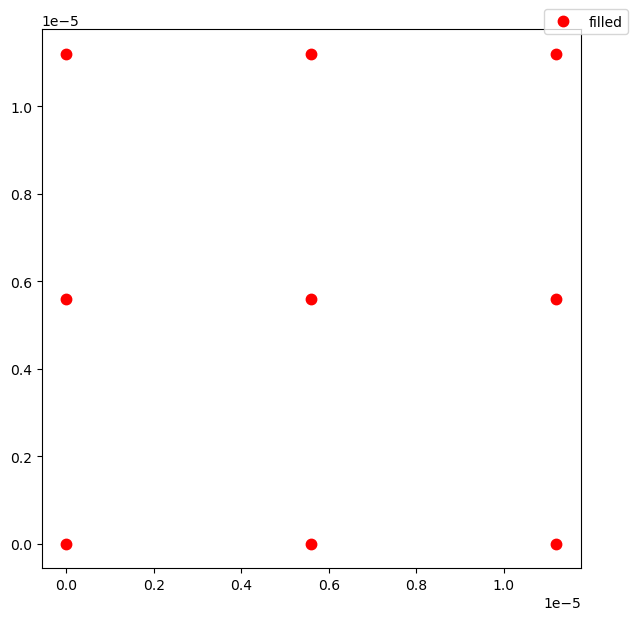

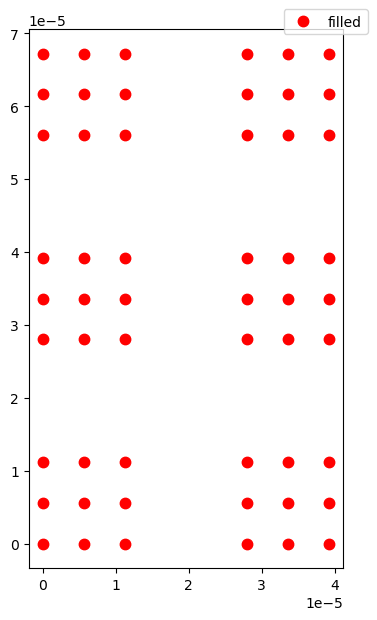

In [35]:
# [Optional] We visually inspect the register
from utils import show_register

show_register(register)
show_register(parallel_register)

## Creating the Checkerboard phase

We use the same values and timings for the Amplitude, Phase, and Detuning from the [Ordered phases in Rydberg Systems](./02_Ordered_phases_in_Rydberg_systems.ipynb) example 

In [37]:
from utils import get_drive

amplitude_min = 0
amplitude_max = 6.3e6  # rad / s
detuning_min = -6e6  # rad / s
detuning_max = 15e6  # rad / s
time_max = 4e-6  # s
time_ramp = 5e-7  # s
time_to_measure = 1e-7 # s

time_points = [0, time_ramp, time_max - time_ramp, time_max]
amplitude_values = [amplitude_min, amplitude_max, amplitude_max, amplitude_min]
detuning_values = [detuning_min, detuning_min, detuning_max, detuning_max]
phase_values = [0, 0, 0, 0]

drive = get_drive(time_points, amplitude_values, detuning_values, phase_values)

In [ ]:
from utils import show_global_drive

# [Optional] We visually inspect the waveforms

show_global_drive(drive)

We now construct the AHS program to be run. Note that we create two programs and execute them to allow us to compare the accuracy of our results, with `parallel_ahs_program` being run on Aquila and `ahs_program` just being simulated with the local simulator. 

In [ ]:
parallel_ahs_program = AnalogHamiltonianSimulation(
    register=parallel_register, 
    hamiltonian=drive
)

ahs_program = AnalogHamiltonianSimulation(
    register=register, 
    hamiltonian=drive
)

ahs_program = ahs_program.discretize(qpu)
parallel_ahs_program = parallel_ahs_program.discretize(qpu)

In [40]:
shots = 100

from braket.devices import LocalSimulator
sim = LocalSimulator("braket_ahs")


qpu_task = qpu.run(parallel_ahs_program, shots=shots)
sim_task = sim.run(ahs_program, shots=len(batch_mapping)*shots).result()

In [48]:
# collecting all data

qpu_results = qpu_task.result()

all_sequences = []
for measurement in qpu_results.measurements:
    for (ix,iy),inds in batch_mapping.items():
        batch_sequence = list(measurement.post_sequence[inds])
        all_sequences.append(batch_sequence)

all_rydberg = 1 - np.array(all_sequences)
qpu_density = all_rydberg.mean(axis=0)


KeyboardInterrupt: 

In [47]:
from utils import get_avg_density
sim_density = get_avg_density(sim_task)

Mention something along the lines of how results are similar enough to simulator to confirm Z2 and furthermore show that batches running in parallel with enough separation avoid unwanted Rydberg interaction/entanglement